In [1]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ReduceLROnPlateau
from numpy import array
from numpy.random import uniform
from numpy import hstack
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas
from scipy import signal
import copy
from sklearn.preprocessing import StandardScaler
from livelossplot import PlotLossesKeras
import csv
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
import random

In [2]:
def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    # Source: https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

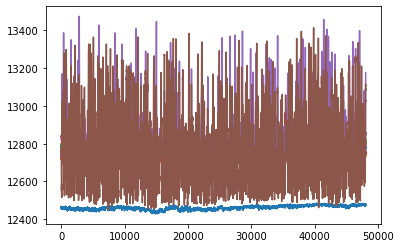

(48052, 16)
[[12761 12735 12794 ... 12733 12748 12779]
 [12762 12731 12785 ... 12724 12742 12786]
 [12763 12732 12791 ... 12734 12745 12777]
 ...
 [12778 12743 12854 ... 12746 13167 13116]
 [12779 12750 12854 ... 12757 13170 13112]
 [12776 12752 12853 ... 12756 13176 13106]]


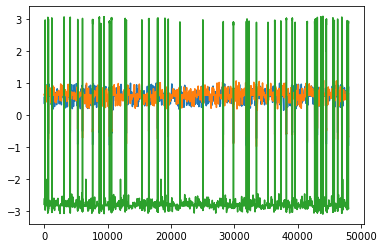

(48052, 3)
[[ 0.554946  0.632542 -2.7831  ]
 [ 0.550505  0.633539 -2.778   ]
 [ 0.545525  0.634378 -2.7742  ]
 ...
 [-0.925561 -0.683579  2.8918  ]
 [-0.930175 -0.682775  2.8857  ]
 [-0.933231 -0.68239   2.8817  ]]


In [3]:
# x, y = create_data(n=400)

# df = pandas.read_csv("50moves.csv", sep=',', header=1)
# dataset = df.values
# trim_start = 200
# trim_end = 8400
# x = dataset[trim_start:trim_end,-16:]
# y = dataset[trim_start:trim_end,5:8]

df = pandas.read_csv("450moves.csv", sep=',', header=0)
dataset = df.values
# trim = 82
# x = dataset[trim+1:-trim,-16:]
# y = dataset[trim+1:-trim,5:8]

x = []
y = []
n = 0
with open('450moves.csv', newline='') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        if n > 0:
            # print(row)
            x.append(row[14:30])
            y.append(row[5:8])
        else:
            n += 1


trim = 50
x = np.array(x[trim:-trim], dtype=int)
y = np.array(y[trim:-trim], dtype=float)
# x = dataset[:,-17:]
# y = dataset[:,5:8]

# x = x.transpose()
# x_filtered = np.array([butter_lowpass_filter(d, 1, 1.5) for d in x])

# x = x_filtered.transpose()
plt.plot(x)
plt.show()
print(x.shape)
print(x)

# x = copy.copy(x_filtered)

plt.plot(y)
plt.show()
print(y.shape)
print(y)

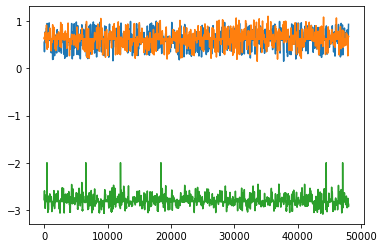

(48052, 3)
[[ 0.554946  0.632542 -2.7831  ]
 [ 0.550505  0.633539 -2.778   ]
 [ 0.545525  0.634378 -2.7742  ]
 ...
 [ 0.925561  0.683579 -2.8918  ]
 [ 0.930175  0.682775 -2.8857  ]
 [ 0.933231  0.68239  -2.8817  ]]


In [4]:
# x = np.transpose(x)
# new_x = []
# for sensor in x:
#     new_x.append(butter_lowpass_filter(sensor,1,10))
# x = np.transpose(new_x)
# plt.plot(x)
# plt.show()
# print(x.shape)
# print(x)


y[:,0] = np.where(y[:,0]<0, -y[:,0], y[:,0])
y[:,1] = np.where(y[:,1]<0, -y[:,1], y[:,1])
y[:,2] = np.where(y[:,2]>0, -y[:,2], y[:,2])
plt.plot(y)
plt.show()
print(y.shape)
print(y)

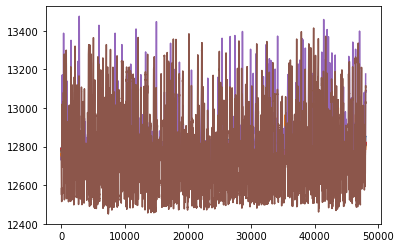

(48052, 6)
[[12794 12764 12785 12789 12748 12779]
 [12785 12764 12783 12784 12742 12786]
 [12791 12760 12783 12790 12745 12777]
 ...
 [12854 12821 12817 12816 13167 13116]
 [12854 12822 12814 12818 13170 13112]
 [12853 12823 12813 12817 13176 13106]]


In [5]:
indices = [2,3,8,9,14,15]
indices = [13,12,11,10,7,6,5,4,1,0]
for ind in indices:
    x = np.delete(x, ind, 1)
x = x.reshape(x.shape[0], x.shape[1])


plt.plot(x)
plt.show()
print(x.shape)
print(x)

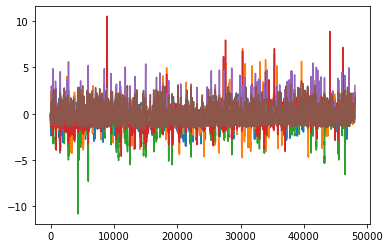

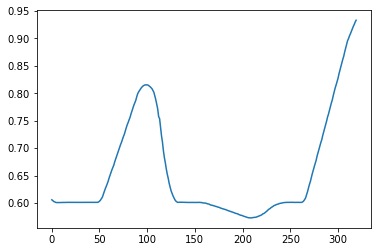

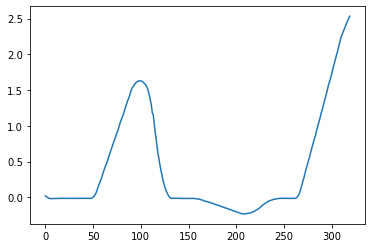

In [6]:
x = StandardScaler().fit_transform(x)
plt.plot(x)
plt.show()
plt.plot(y[-320:,0])
plt.show()
y = StandardScaler().fit_transform(y)
plt.plot(y[-320:,0])
plt.show()
# print(x)
# print(y)
x = x.reshape(x.shape[0], x.shape[1], 1)
# print("x:", x.shape, "y:", y.shape)
in_dim = (x.shape[1], x.shape[2])
out_dim = y.shape[1]
# print(in_dim)
# print(out_dim)
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.25, shuffle=False)
# print("xtrain:", xtrain.shape, "ytrain:", ytrain.shape)

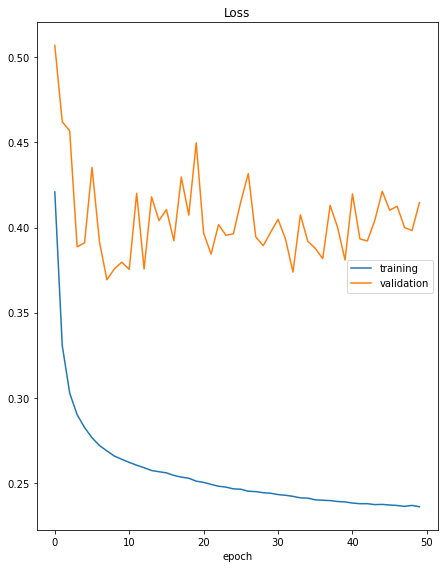

Loss
	training         	 (min:    0.236, max:    0.421, cur:    0.236)
	validation       	 (min:    0.369, max:    0.507, cur:    0.415)
Train: 0.236, Test: 0.415


In [7]:
trainx = copy.copy(xtrain)
testx = copy.copy(xtest)
trainy = copy.copy(ytrain)
testy = copy.copy(ytest)

trainx = trainx.reshape(trainx.shape[0], trainx.shape[1])
testx = testx.reshape(testx.shape[0], testx.shape[1])
# print(type(trainx))
print(trainx)
print(trainy)
shuffling = list(zip(trainx, trainy))
random.shuffle(shuffling)
trainx, trainy = zip(*shuffling)
trainx=np.array(list(trainx))
trainy=np.array(list(trainy))
# print(type(trainx))
print(trainx)
print(trainy)
print("trainx:", trainx.shape, "trainy:", trainy.shape)

# define model
model = Sequential()
model.add(Dense(32, input_dim=6, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
# fit model
history = model.fit(trainx, trainy, validation_data=(testx, testy), batch_size=32, epochs=50, verbose=0, callbacks=[PlotLossesKeras()])
# evaluate the model
train_mse = model.evaluate(trainx, trainy, verbose=0)
test_mse = model.evaluate(testx, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plt.title('Loss / Mean Squared Error')
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()

y1 MSE:0.2726
y2 MSE:0.5218
y3 MSE:0.4495
y1-train MSE:1.7385
y2-train MSE:1.8032
y3-train MSE:1.6470


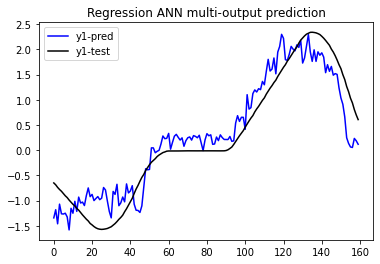

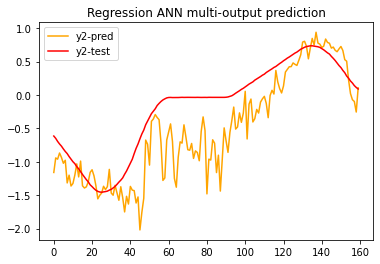

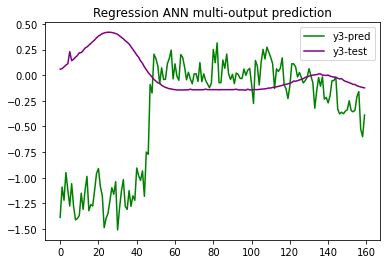

In [8]:
predictions = model.predict(testx) 
print("y1 MSE:%.4f" % mean_squared_error(testy[:,0], predictions[:,0]))
print("y2 MSE:%.4f" % mean_squared_error(testy[:,1], predictions[:,1]))
print("y3 MSE:%.4f" % mean_squared_error(testy[:,2], predictions[:,2]))

predictions_train = model.predict(xtrain)
print("y1-train MSE:%.4f" % mean_squared_error(trainy[:,0], predictions_train[:,0]))
print("y2-train MSE:%.4f" % mean_squared_error(trainy[:,1], predictions_train[:,1]))
print("y3-train MSE:%.4f" % mean_squared_error(trainy[:,2], predictions_train[:,2]))

N = len(testx)
N = 160
x_ax = range(len(testx))[:N]
plt.title("Regression ANN multi-output prediction")
plt.plot(x_ax, predictions[:N,0], label="y1-pred", color='blue')
plt.plot(x_ax, testy[:N,0], label="y1-test", color='black')
plt.legend()
plt.show()

plt.title("Regression ANN multi-output prediction")
plt.plot(x_ax, predictions[:N,1], label="y2-pred", color='orange')
plt.plot(x_ax, testy[:N,1], label="y2-test", color='red')
plt.legend()
plt.show()

plt.title("Regression ANN multi-output prediction")
plt.plot(x_ax, predictions[:N,2], label="y3-pred", color='green')
plt.plot(x_ax, testy[:N,2], label="y3-test", color='purple')
plt.legend()
plt.show()

In [9]:
model = Sequential()
model.add(LSTM(10, input_shape=in_dim, activation="relu"))
# model.add(LSTM(32))
model.add(Dense(out_dim))
model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense_3 (Dense)             (None, 3)                 33        
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


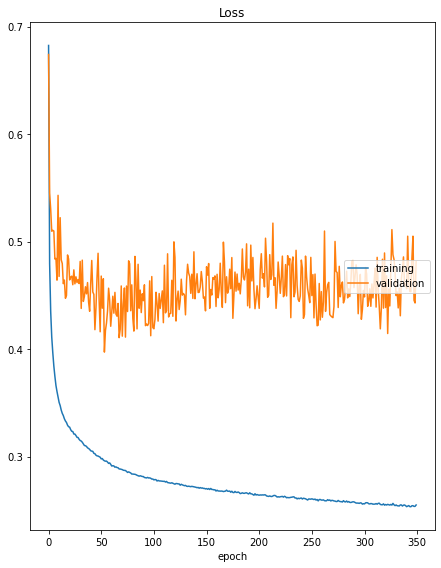

Loss
	training         	 (min:    0.253, max:    0.682, cur:    0.255)
	validation       	 (min:    0.397, max:    0.674, cur:    0.481)


In [10]:
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=350, batch_size=128, verbose=0, callbacks=[PlotLossesKeras()]) #callbacks=[reduce_lr]
# plt.title('Loss / Mean Squared Error')
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()

In [11]:
print(len(trainx)//8)

ypred = model.predict(xtest)
print("y1-test MSE:%.4f" % mean_squared_error(ytest[:,0], ypred[:,0]))
print("y2-test MSE:%.4f" % mean_squared_error(ytest[:,1], ypred[:,1]))
print("y3-test MSE:%.4f" % mean_squared_error(ytest[:,2], ypred[:,2]))

ypred_train = model.predict(xtrain)
print("y1-train MSE:%.4f" % mean_squared_error(ytrain[:,0], ypred_train[:,0]))
print("y2-train MSE:%.4f" % mean_squared_error(ytrain[:,1], ypred_train[:,1]))
print("y3-train MSE:%.4f" % mean_squared_error(ytrain[:,2], ypred_train[:,2]))


4504
y1-test MSE:0.3965
y2-test MSE:0.5495
y3-test MSE:0.4980
y1-train MSE:0.1887
y2-train MSE:0.2079
y3-train MSE:0.3673


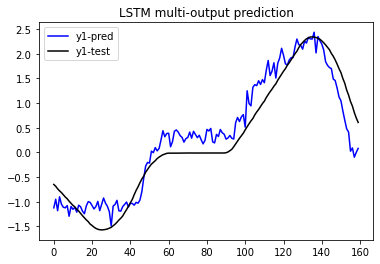

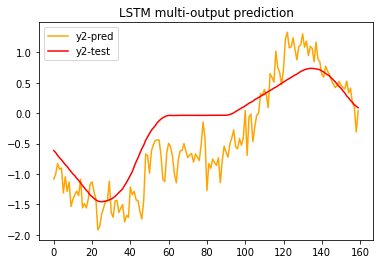

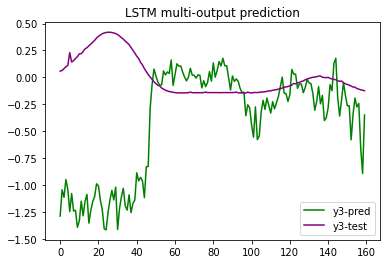

In [12]:
N = len(xtest)
N=160
x_ax = range(len(xtest))[:N]

plt.title("LSTM multi-output prediction")
# plt.scatter(x_ax, ytest[:N,0],  s=15, label="y1-test", color='black')
plt.plot(x_ax, ypred[:N,0], label="y1-pred", color='blue')
plt.plot(x_ax, ytest[:N,0], label="y1-test", color='black')
plt.legend()
plt.show()

plt.title("LSTM multi-output prediction")
# plt.scatter(x_ax, ytest[:N,1],  s=15, label="y2-test", color='red')
plt.plot(x_ax, ypred[:N,1], label="y2-pred", color='orange')
plt.plot(x_ax, ytest[:N,1],  label="y2-test", color='red')
plt.legend()
plt.show()

plt.title("LSTM multi-output prediction")
# plt.scatter(x_ax, ytest[:N,2],  s=15, label="y3-test", color='purple')
plt.plot(x_ax, ypred[:N,2], label="y3-pred", color='green')
plt.plot(x_ax, ytest[:N,2], label="y3-test", color='purple')
plt.legend()
plt.show()

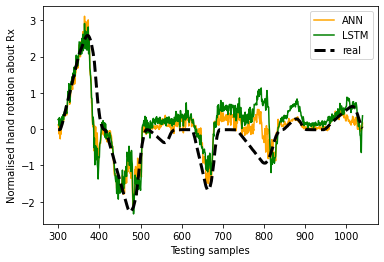

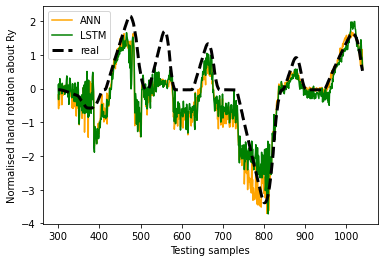

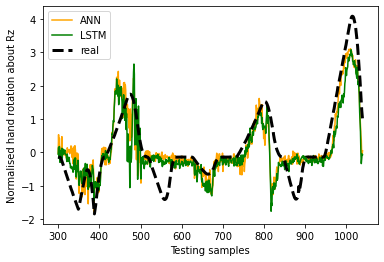

In [13]:
N1 = 300
# N2 = len(xtest)
N2 = N1 + 740
x_ax = range(len(xtest))[N1:N2]

# plt.title("y1-pred")
# plt.scatter(x_ax, ytest[:N,0],  s=15, label="real", color='black')
plt.plot(x_ax, predictions[N1:N2,0], label="ANN", color='orange')
plt.plot(x_ax, ypred[N1:N2,0], label="LSTM", color='green')
plt.plot(x_ax, ytest[N1:N2,0], '--', label="real", color='black', linewidth = 3)
plt.xlabel("Testing samples")
plt.ylabel("Normalised hand rotation about Rx")
plt.legend()
plt.show()

# plt.title("y2-pred")
plt.plot(x_ax, predictions[N1:N2,1], label="ANN", color='orange')
plt.plot(x_ax, ypred[N1:N2,1], label="LSTM", color='green')
plt.plot(x_ax, ytest[N1:N2,1], '--', label="real", color='black', linewidth = 3)
plt.xlabel("Testing samples")
plt.ylabel("Normalised hand rotation about Ry")
plt.legend()
plt.show()

# plt.title("y3-pred")
plt.plot(x_ax, predictions[N1:N2,2], label="ANN", color='orange')
plt.plot(x_ax, ypred[N1:N2,2], label="LSTM", color='green')
plt.plot(x_ax, ytest[N1:N2,2], '--', label="real", color='black', linewidth = 3)
plt.xlabel("Testing samples")
plt.ylabel("Normalised hand rotation about Rz")
plt.legend()
plt.show()